# Simple pendulum

In [3]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))


import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import sympy
from dae_finder import construct_reduced_fit_list

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




from matplotlib import pyplot as plt
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from dae_finder import get_simplified_equation_list
from dae_finder import get_refined_lib, remove_paranth_from_feat
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder
from dae_finder import PolyFeatureMatrix
from copy import deepcopy



/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder


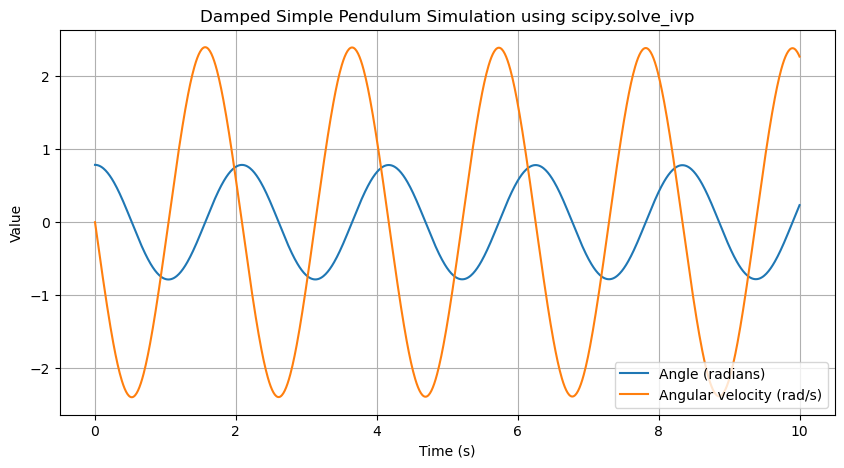

In [30]:


# Function to compute derivatives
def pendulum_rhs(t, y, gamma, L=1):
    """
    Function to compute derivatives for simple pendulum with damping
    
    Parameters:
        t : float
            Time
        y : array_like
            Vector containing [theta, omega], where
            theta is the angle and omega is the angular velocity
        gamma : float
            Damping coefficient
        L : float
            Length of the pendulum
        
    Returns:
        dydt : array_like
            Vector containing [omega, alpha], where
            omega is the angular velocity and alpha is the angular acceleration
    """
    theta, omega = y
    alpha = - (9.81 / L) * np.sin(theta) - gamma * omega
    return [omega, alpha]

# Parameters
theta0 = np.pi / 4  # Initial angle (radians)
omega0 = 0.0        # Initial angular velocity (radians per second)
gamma = 0.0       # Damping coefficient
L = 1.0             # Length of the pendulum (meters)
t_span = (0, 10)    # Time span for the simulation

# Function to integrate the system of ODEs
def integrate_pendulum(t_span, y0, gamma, L):

    sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, y0, method='RK45', t_eval=np.linspace(*t_span, 1000))
    return sol

# Integrate the pendulum system
sol = integrate_pendulum(t_span, [theta0, omega0], gamma, L)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label='Angle (radians)')
plt.plot(sol.t, sol.y[1], label='Angular velocity (rad/s)')
plt.title('Damped Simple Pendulum Simulation using scipy.solve_ivp')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

wrong_relation_dict = {}

In [31]:
IC_df = pd.read_csv(os.path.join(path_to_add, "parameters/init_cond_simp_pend.csv"))
# IC_df = IC_df.iloc[[0,3]]
params_df = pd.read_csv(os.path.join(path_to_add, "parameters/pend_param.csv"))
g = 9.81   # Acceleration due to gravity (m/s^2)

### Synthesizing data from different ICs

In [83]:
L = 5.0
# y_shift = 0.9 * L
# y_shift = 0
noise_perc = 0.01
wrong_relation_dict[noise_perc] = []

num_time_points = 200
# Time span
t_span = (0.0, 10)  # from 0 to 10 seconds
#Valuation points
t_eval_ = np.linspace(t_span[0], t_span[1], num_time_points)
data_matrix_df_list = []


for param_index in params_df.index:
    params = params_df.loc[param_index]
    # Define parameters
    m_c = params['m_c']  # Mass of the cart (kg)
    m_p = params['m_p']  # Mass of the pendulum (kg)
    l = params['l']    # Length of the pendulum (m)
    for IC_index in IC_df.index:
        IC = IC_df.loc[IC_index]
        y0 = IC.values
                # Parameters
        theta0 = IC["theta"]  # Initial angle (radians)
        omega0 = IC["omega"]        # Initial angular velocity (radians per second)
        gamma = 0.0         # Damping coefficient
        # Solve the ODEs
        # sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, [theta0, omega0], method='RK45', t_eval=t_eval_)
        sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, [theta0, omega0], t_eval=t_eval_, rtol=1e-8)
        
        sol_df = pd.DataFrame(sol.y.T, columns=["theta", "omega"])
        sol_df["x"] = L*np.sin(sol_df["theta"])
        sol_df["y"] = -L*np.cos(sol_df["theta"])
        sol_df["t"] = t_eval_
        data_matrix_df_list.append(sol_df[["t", "x", "y"]])
        # if IC_index == 0:
        #     # Plot the results
        #     plt.figure(figsize=(10, 6))
        #     plt.plot(sol.t, sol.y[0], label='Cart Position (x)')
        #     plt.plot(sol.t, sol.y[2], label='Pendulum Angle (theta)')
        #     plt.xlabel('Time (s)')
        #     plt.ylabel('Position (m) / Angle (rad)')
        #     plt.title('Upright Pendulum on Moving Cart')
        #     plt.legend()
        #     plt.grid(True)
        #     plt.show()

data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
print("# data points per IC: {}".format(data_matrix_df.shape[0]/len(IC_df)))


# Adding noise to time-series
sys.path.append(os.path.join(path_to_add, "daeFinder"))

data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["t"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["t"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df


## Plotting noisy times-series
# plt.plot(data_matrix_df_list[3]["t"], data_matrix_df_list[3]["x"], data_matrix_df_list[3]["t"], data_matrix_df_list[3]["y"])


# data points per IC: 200.0


### Smoothing data and finding derivatives

In [84]:


data_amplify_fact = 1
num_smoothed_points = num_time_points*data_amplify_fact


t_eval_new = np.linspace(data_matrix_df_list[0]["t"].iloc[0], data_matrix_df_list[0]["t"].iloc[-1], num_smoothed_points)

#Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix,derr_order=1, noise_perc=noise_perc, eval_points=t_eval_new) for data_matrix in data_matrix_df_list]

if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list[:-1], ignore_index=True)

data_matrix_df_smooth = data_matrix_df_smooth_appended[["x","y", "d(x) /dt", "d(y) /dt"]]
data_matrix_df_smooth = data_matrix_df_smooth.iloc[5:-5]

#Removing big bumps in the time series due to noise
# new_df = deepcopy(data_matrix_df_smooth)
# new_df["energy"] = 0.5*((new_df["d(x) /dt"])**2 + (new_df["d(y) /dt"])**2) +  9.81*new_df["y"]
# data_matrix_df_smooth = data_matrix_df_smooth[abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()]
# data_matrix_df_smooth = data_matrix_df_smooth.rename(columns= dict(zip(data_matrix_df_smooth, ['x', 'y', 'x_dot', 'y_dot'])))



# #Plotting smoothened splines

# ind = 1
# feature_ = "y"

# plt.figure()
# # plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
# #         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

# plt.plot(data_matrix_df_list[ind]["t"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["t"],
#          data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["t"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
# plt.legend(['Noisy', 'Cubic Spline', 'True'])
# # plt.axis([-0.05, 6.33, -1.05, 1.05])
# plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
# plt.show()

# data_matrix_smooth_df_list[0][["d(x) /dt"]].plot()

## Forming candiate library

In [86]:
len(data_matrix_df_list[0])

200

In [87]:
plt.plot(data_matrix_df_smooth[:num_time_points]["t"],
         data_matrix_df_smooth[:num_time_points]["x"],
         data_matrix_df_smooth[:num_time_points]["t"],
         data_matrix_df_smooth[:num_time_points]["y"])

data_matrix_df_list[0][["x","y"]].plot()

KeyError: 't'

In [69]:
poly_degree = 3

poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)

candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))


Degree of library: 3
# terms in the library: 34
Full candidate library has the following features: Index(['x', 'y', 'x_dot', 'y_dot', 'x^2', 'x y', 'x x_dot', 'x y_dot', 'y^2',
       'y x_dot', 'y y_dot', 'x_dot^2', 'x_dot y_dot', 'y_dot^2', 'x^3',
       'x^2 y', 'x^2 x_dot', 'x^2 y_dot', 'x y^2', 'x y x_dot', 'x y y_dot',
       'x x_dot^2', 'x x_dot y_dot', 'x y_dot^2', 'y^3', 'y^2 x_dot',
       'y^2 y_dot', 'y x_dot^2', 'y x_dot y_dot', 'y y_dot^2', 'x_dot^3',
       'x_dot^2 y_dot', 'x_dot y_dot^2', 'y_dot^3'],
      dtype='object')


## Finding the remaining algebraic relationships

In [70]:

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df_smooth.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df_smooth.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")




seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.01, coef_threshold= 0.001)
# seq_th_model = sequentialThLin(model_id="LR", alhp coef_threshold= 0.1)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_full, scale_columns= False)

algebraic_model_th.best_models()

Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

,x,y_dot,x_dot,y,x_dot^3,y^2,y x_dot,x y,y^3,x^2 y_dot,...,x_dot^2 y_dot,y^2 y_dot,x x_dot^2,x_dot y_dot,x x_dot y_dot,y x_dot y_dot,x y y_dot,x x_dot,x y x_dot,x y_dot
y,0.00000000,0.00000000,0.00000000,NaN,-0.05201209,0.01262783,-0.00264873,0.00000000,0.43968666,0.04695707,...,-0.18858398,0.04915071,-0.15833929,0.00644626,-0.04193063,-0.21809765,0.02022564,-0.01062222,0.05121369,-1.81015430
x_dot,0.00000000,0.00000000,NaN,0.00000000,0.32370488,0.00000000,0.01647400,0.00613228,-0.03107292,0.04898659,...,-0.16770888,-0.03801519,0.14352805,0.00236757,-0.06000723,0.08266930,-0.10982631,0.05765131,-0.24602243,15.72376234
y_dot,0.00000000,NaN,0.00000000,0.00000000,-0.06990949,0.00189237,-0.00354150,0.00000000,0.00000000,3.31147049,...,1.08187633,2.39632885,-0.15423613,-0.03239156,-0.02218344,-0.20095159,0.07026641,-0.04475513,0.07701494,-11.66078284
x^2,0.00337383,0.00000000,-0.00278241,-0.02036164,0.11015448,-0.19354501,0.00561386,-0.00887883,-1.12889456,-0.33879225,...,1.24187517,-0.03311304,-0.86362842,0.04005977,2.01284158,-0.88398166,0.46385714,0.01267873,0.70216431,-49.20027167
x y,0.00000000,0.00000000,0.00000000,0.00000000,0.98880821,0.00996681,0.05039701,NaN,-0.10062740,-0.03059881,...,0.13983651,0.04730091,-11.20181135,-1.92087609,-0.76770254,-5.03057772,-0.86422716,-0.13349863,0.20493223,-135.49765524
x x_dot,0.00000000,-0.00250479,0.00000000,0.00000000,-0.34780742,0.00000000,-0.01770969,-0.00906133,-0.05417750,-0.04243114,...,0.19666927,0.17882746,0.20150802,-0.08219640,-0.35667380,0.10590829,0.01118148,NaN,0.70049187,53.06666143
x y_dot,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN
y^2,0.00000000,0.00000000,0.00417110,0.00988792,0.23448113,NaN,0.01187390,0.01577498,1.94539571,0.35335370,...,-1.32777063,0.02920908,0.77631486,-0.14456254,-1.28982558,0.28025116,-0.25258803,0.00779373,-0.75279721,29.42466056
y x_dot,0.00000000,0.00000000,0.00000000,0.00000000,-19.62145470,0.00000000,NaN,0.04662774,0.00000000,0.76886273,...,-2.97255008,0.90902629,-0.05714741,-0.12086120,0.66217596,-1.44045028,0.40743617,-0.19106720,1.20042145,110.48641498
y y_dot,0.00000000,-0.00249762,0.00000000,0.00000000,-1.89486169,-0.02116708,-0.09653413,-0.00906597,-0.05424263,4.94122976,...,-19.42323160,3.70477164,0.20171815,0.01342555,-1.07438440,0.34353768,0.25743351,-0.94261406,0.55245648,162.49539175


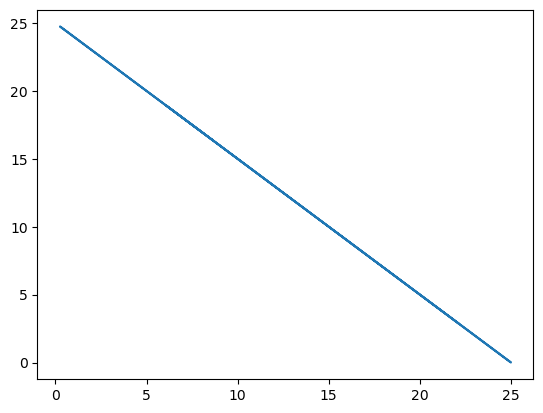

In [71]:
plt.plot(candidate_lib_full["x^2"], candidate_lib_full["y^2"])

In [74]:
algebraic_model_th.best_models()["x^2"]

y               -0.03148163
x_dot            0.00000000
y_dot            0.00248276
x^2                     NaN
x y              0.00000000
x x_dot          0.00000000
x y_dot          0.00000000
y^2             -0.24094466
y x_dot          0.00000000
y y_dot          0.02629449
x_dot^2         -0.01495354
x_dot y_dot      0.00000000
y_dot^2          0.04918635
x^3              0.00000000
x^2 y           -0.05410244
x^2 x_dot        0.00441047
x^2 y_dot       -0.00468130
x y^2            0.00000000
x y x_dot        0.00467419
x y y_dot        0.00440738
x x_dot^2       -0.00312475
x x_dot y_dot    0.00830423
x y_dot^2        0.00000000
y^3             -0.10446830
y^2 x_dot        0.00000000
y^2 y_dot        0.00000000
y x_dot^2        0.02752694
y x_dot y_dot   -0.00311477
y y_dot^2        0.03581703
x_dot^3          0.00000000
x_dot^2 y_dot    0.00134040
x_dot y_dot^2    0.00000000
y_dot^3          0.00134240
x                0.00000000
r2- metric       0.99999976
Name: x^2, dtype: fl

In [49]:
best_models_full = algebraic_model_th.best_models(1)


intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df_smooth.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

In [50]:

reduced_relationship_features = construct_reduced_fit_list(candidate_lib_full.columns, simplified_eqs=simplified_equations)

reduced_relationship_features
best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)

best_relationship_set = set(best_relationship)

***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 0:  Cannot initialize from 'dict' without generators


In [51]:
simplified_equations

{'x_dot': {'lhs': 1, 'rhs': 0}}

In [46]:
best_relationship_set

{'x x_dot', 'y y_dot'}

In [28]:
true_relationship_dict_2degree = {
    1: {'y^2', 'x^2'},
    2: {'y', 'x_dot^2', 'y_dot^2'}
}

relationship_refinement_2degree = {
    1: {'x^2','x*x_dot'},
    2: {'x_dot^2'}
}

In [29]:
discovered_true = False
relationship_index = None

for key_,value_ in true_relationship_dict_2degree.items():
    if best_relationship_set == value_:
        discovered_true = True
        relationship_index = key_
if not discovered_true:
    wrong_relation_dict[noise_perc].append(simplified_equations)

features_to_remove =[sympy.sympify(feature) for feature in relationship_refinement_2degree[relationship_index]]

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_smooth,
                                                  candidate_lib_full, get_dropped_feat=True)

seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.3, coef_threshold= 0.05)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)


best_models_full = algebraic_model_th.best_models(1)


intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df_smooth.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

reduced_relationship_features = construct_reduced_fit_list(candidate_lib_full.columns, simplified_eqs=simplified_equations)

reduced_relationship_features
best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)

best_relationship_set = set(best_relationship)

discovered_second_true = False
relationship_index = None

for key_,value_ in true_relationship_dict_2degree.items():
    if best_relationship_set == value_:
        discovered_second_true = True
        relationship_index = key_

if not discovered_second_true:
    wrong_relation_dict[noise_perc].append(simplified_equations)


KeyError: None

In [266]:
#Use lasso model by default
algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.3, fit_intercept=True)
algebraic_model_1.fit(candidate_lib_full, scale_columns= True)


algebraic_model_1.best_models(5)

,x y,y y_dot,x x_dot,x,x_dot
x,0.00000000,0.00000000,-0.00000000,NaN,0.00000000
y,0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000
x_dot,0.00000000,-0.00000000,0.00000000,0.00000000,NaN
y_dot,0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000
x^2,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x x_dot,0.00000000,-0.16819653,NaN,-0.00000000,0.00000000
x y_dot,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y^2,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000
y x_dot,-0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000
y y_dot,-0.00000000,NaN,-0.25102333,0.00000000,-0.00000000


In [157]:
features_to_remove = {x**2, x*x_dot}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_smooth,
                                                  candidate_lib_full, get_dropped_feat=True)

In [874]:
#Use lasso model by default
algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.2, fit_intercept=True)

# algebraic_model_1.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt"], axis=1), scale_columns= True)
algebraic_model_1.fit(refined_candid_lib, scale_columns= True)


algebraic_model_1.best_models(5)

,x_dot y_dot^2,y_dot^3,y^3,x,x_dot
x,-0.00000000,0.00000000,0.00000000,NaN,0.00000000
y,-0.00000000,0.00000000,6.37522289,0.00000000,0.00000000
x_dot,44.83351137,0.00000000,-0.00000000,0.00000000,NaN
y_dot,0.00000000,58.98632538,0.00000000,-0.00000000,-0.00000000
x y,0.00000000,0.00000000,-0.00000000,0.04211228,0.00000000
x y_dot,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000
y^2,0.00000000,0.00000000,1.87045213,0.00000000,0.00000000
y x_dot,-7.95290645,-0.00000000,0.00000000,0.00000000,0.00000000
y y_dot,-0.00000000,-5.37775586,-0.00000000,-0.00000000,-0.00000000
x_dot^2,0.00000000,-0.00000000,-0.17574538,-0.00000000,0.00000000


In [797]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["y x_dot", "y^2 x_dot"]], y=candidate_lib_full["x_dot^3"])
model_lin.score(X=candidate_lib_full[["y x_dot", "y^2 x_dot"]], y=candidate_lib_full["x_dot^3"])

KeyError: 'x_dot^3'

In [798]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["y", "x_dot^2"]], y=candidate_lib_full["x_dot^2"])
model_lin.score(X=candidate_lib_full[["y", "x_dot^2"]], y=candidate_lib_full["x_dot^2"])

1.0

In [718]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'y': -1.3657439784125636e-15, 'x_dot^2': 1.0000000000000002}

In [719]:
model_lin.intercept_

3.552713678800501e-15

# FInal param est

In [ ]:

model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2"]], y=candidate_lib_full["y"])
model_lin.score(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2"]], y=candidate_lib_full["y"])

0.9918091633484667

In [268]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'x_dot^2': -0.051864451499145,
 'y_dot^2': -0.05106337810338052,
 'y^2': 0.002454517776341498}

In [ ]:

model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2", "y^3"]], y=candidate_lib_full["y"])
model_lin.score(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2", "y^3"]], y=candidate_lib_full["y"])

0.9938652824568117

In [913]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'x_dot^2': -0.026412190860826464,
 'y_dot^2': -0.049406277943368125,
 'y^2': -0.09031253560445782,
 'y^3': 0.024188940537223962}

In [247]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2", "x_dot y_dot"]], y=candidate_lib_full["y"])
model_lin.score(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2", "x_dot y_dot"]], y=candidate_lib_full["y"])

0.9999068525947747

In [248]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'x_dot^2': -0.05104276845691093,
 'y_dot^2': -0.0510480714267504,
 'y^2': -6.73522336734388e-05,
 'x_dot y_dot': -2.1570969168485095e-05}

In [631]:
model_lin.intercept_

AttributeError: 'LinearRegression' object has no attribute 'intercept_'

In [632]:
# Expected coefficient of x_dot^2 and y_dot^2 
1/(9.8*2) #1/2 * 1/g

0.0510204081632653

In [633]:
# Expected intercept (coming from energy)
L #L

5.0

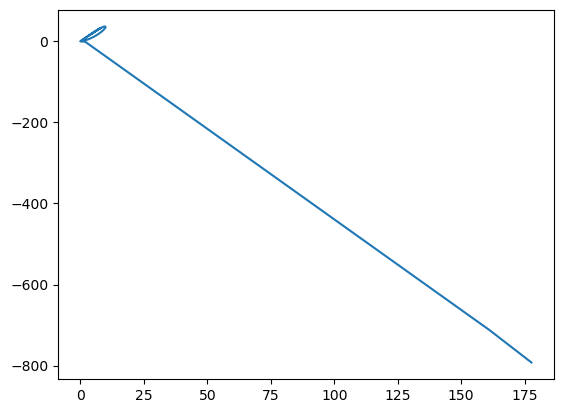

In [634]:
plt.plot(candidate_lib_full["x_dot^2"][:50], candidate_lib_full["y x_dot^2"][:50])

In [540]:
plt.plot(candidate_lib_full["y^3"][:100000], candidate_lib_full["x_dot^2"][:100000])

KeyError: 'y^3'

In [1558]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["y^2", "d(y) /dt^2"]], y=candidate_lib_full["x^2"])

### SVD analysis

In [ ]:
pca_1 = decomposition.PCA()
pca_1.fit(candidate_lib_full)


pca_2 = decomposition.PCA()
pca_2.fit(candidate_lib_full.drop(["x^2", "x x_dot"],axis=1))

pca_3 = decomposition.PCA()
pca_3.fit(candidate_lib_full.drop(["x^2", "x x_dot", "y"],axis=1))


var_expl_ratio = pca_1.explained_variance_ratio_
theta_dot_sq_rem_expl_ratio = pca_2.explained_variance_ratio_
theta_dot_rem_expl_ratio = pca_3.explained_variance_ratio_


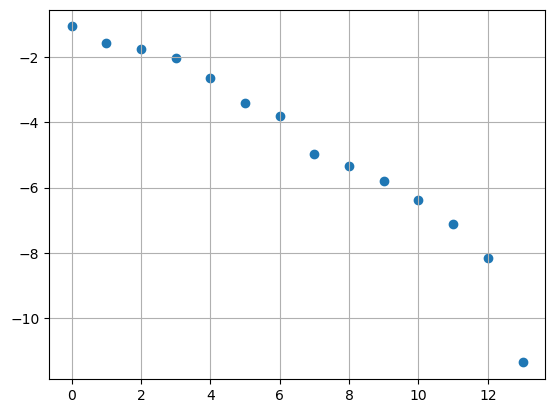

In [ ]:

plt.scatter(np.arange(len(var_expl_ratio)),np.log(var_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

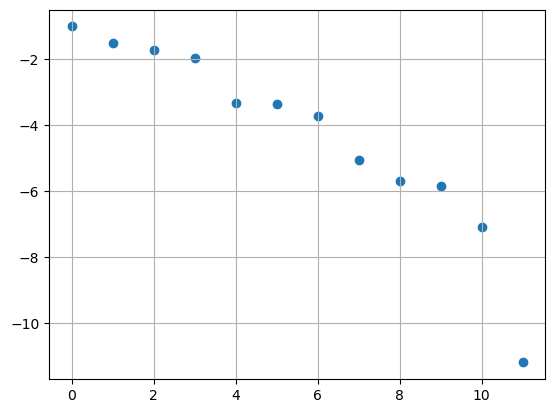

In [ ]:

plt.scatter(np.arange(len(theta_dot_sq_rem_expl_ratio)),np.log(theta_dot_sq_rem_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

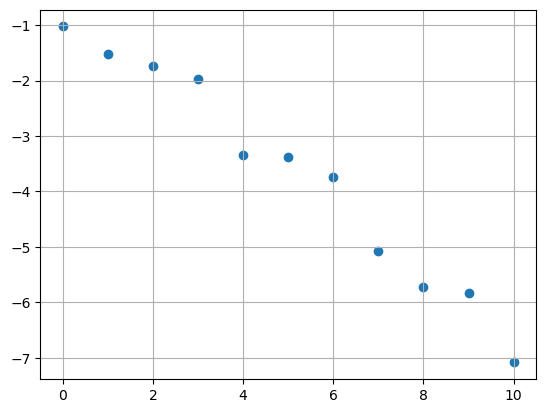

In [ ]:

plt.scatter(np.arange(len(theta_dot_rem_expl_ratio)),np.log(theta_dot_rem_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)